# Final Case Study
Predict the critical temperature for materials based on extracted features

# Imports

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import heapq
import joblib
import re
import os
import xgboost as xgb
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, root_mean_squared_log_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime

# Dataset

In [114]:
# The decision on the train test splitting size is arbitrary but gives a descent balance
# The decision on the random states are relatively arbitrary but the number 42 seems to provide descent results
split_test_size = 0.2
split_rand_state = 42
model_rand_state = 42


## Dataset Info

In [115]:
df_train = pd.read_csv('./train.csv')

In [116]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

## Dataset Cleaning and Preparation

In [117]:
# These assume that there are infinite or missing values (an error that google colab throws if these aren't done)
# Drop rows with missing or infinite values in the target variable
df_train = df_train[df_train['critical_temp'].notna() & np.isfinite(df_train['critical_temp'])]
# Reset index after removing na
df_train = df_train.reset_index(drop=True)

In [ ]:
X = df_train.drop(columns=['critical_temp'])
y = df_train['critical_temp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=split_rand_state)

# Model

In [119]:
model = xgb.XGBRegressor(device="cuda", random_state=model_rand_state)
model_GSCV = xgb.XGBRegressor(device="cuda", random_state=model_rand_state)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
xgb.plot_importance(model, importance_type='weight', title='Feat. Import. - Weight')

<Axes: title={'center': 'Feat. Import. - Gain'}, xlabel='Importance score', ylabel='Features'>

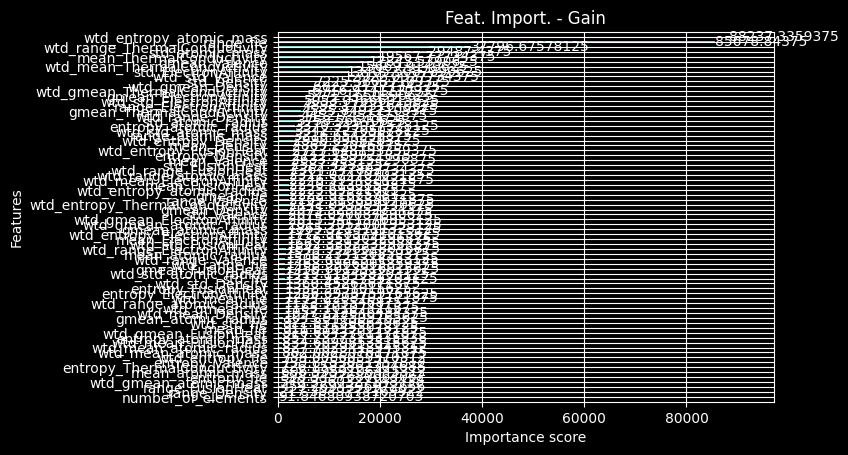

In [121]:
xgb.plot_importance(model, importance_type='gain', title='Feat. Import. - Gain')

## GridSearch

In [10]:
param_grid = {
    'n_estimators': [50, 100, 200],           # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.1, 0.2],        # Step size at each iteration while moving towards a minimum of a loss function
    'max_depth': [7, 8, 9],                    # Maximum depth of a tree
    'subsample': [0.8, 0.9, 1.0],              # Fraction of samples used for fitting trees
    'colsample_bytree': [0.8, 0.9, 1.0],      # Fraction of features used for each tree
    'gamma': [0, 0.1, 0.2]                    # Minimum loss reduction required to make a further partition
}

In [35]:
grid_search = GridSearchCV(estimator=model_GSCV, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


In [ ]:
# Google colab found these values in 33 minutes
# colsample_bytree: 0.8, gamma: 0, learning_rate: 0.1, max_depth: 7, n_estimators: 200, subsample: 0.9
print("Best Parameters:", grid_search.best_params_)
# RMSE: 8.98511
# MSE: 80.73217
# Mean AE: 5.36274
# Median AE: 2.76572
# R^2: 0.92986

# Predictions

In [122]:
pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
meanae = mean_absolute_error(y_test, pred)
medae = median_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

In [123]:
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Mean Absolute Error (MAE): {meanae:.5f}")
print(f"Median Absolute Error (MAE): {medae:.5f}")
print(f"R^2 Error (R^2): {r2:.5f}")

Root Mean Squared Error (RMSE): 9.35742
Mean Squared Error (MSE): 87.56128
Mean Absolute Error (MAE): 5.63836
Median Absolute Error (MAE): 2.96643
R^2 Error (R^2): 0.92393


In [ ]:
# Evaluate the model with the best parameters from the Grid Search
best_model = grid_search.best_estimator_
grid_pred = best_model.predict(X_test)
grid_rmse = root_mean_squared_error(y_test, grid_pred)
grid_mse = mean_squared_error(y_test, grid_pred)
grid_meanae = mean_absolute_error(y_test, grid_pred)
grid_medae = median_absolute_error(y_test, grid_pred)
grid_r2 = r2_score(y_test, grid_pred)

In [ ]:
print(f"Root Mean Squared Error (RMSE): {grid_rmse:.5f}")
print(f"Mean Squared Error (MSE): {grid_mse:.5f}")
print(f"Mean Absolute Error (MAE): {grid_meanae:.5f}")
print(f"Median Absolute Error (MAE): {grid_medae:.5f}")
print(f"R^2 Error (R^2): {grid_r2:.5f}")

# Saving the Model

In [11]:
pkl_files = [f for f in os.listdir("./") if f.endswith('.pkl')]
pattern = re.compile(r'bestmdlv(\d+)\.pkl')

existing_versions = [
    int(match.group(1))
    for file in pkl_files
        if (match := pattern.match(file))
]

next_num = max(existing_versions, default=0) + 1
next_filename = f'bestmdlv{next_num}.pkl'

print(f"The following versions are found: {pkl_files}")
print(f"Next name: {next_filename}")

The following versions are found: ['bestmdlv1.pkl', 'bestmdlv2.pkl']
Next name: bestmdlv3.pkl


In [12]:
for params in param_grid:
    print(params)
    print(param_grid[params])

n_estimators
[50, 100, 200]
learning_rate
[0.01, 0.1, 0.2]
max_depth
[7, 8, 9]
subsample
[0.8, 0.9, 1.0]
colsample_bytree
[0.8, 0.9, 1.0]
gamma
[0, 0.1, 0.2]


In [13]:
loaded_mdlv1 = joblib.load('bestmdlv1.pkl')
loaded_mdlv2 = joblib.load('bestmdlv2.pkl')

C:\Program Files\Python312\Lib\pickle.py:1760: UserWarning: [00:40:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [ ]:
# joblib.dump(model, "")

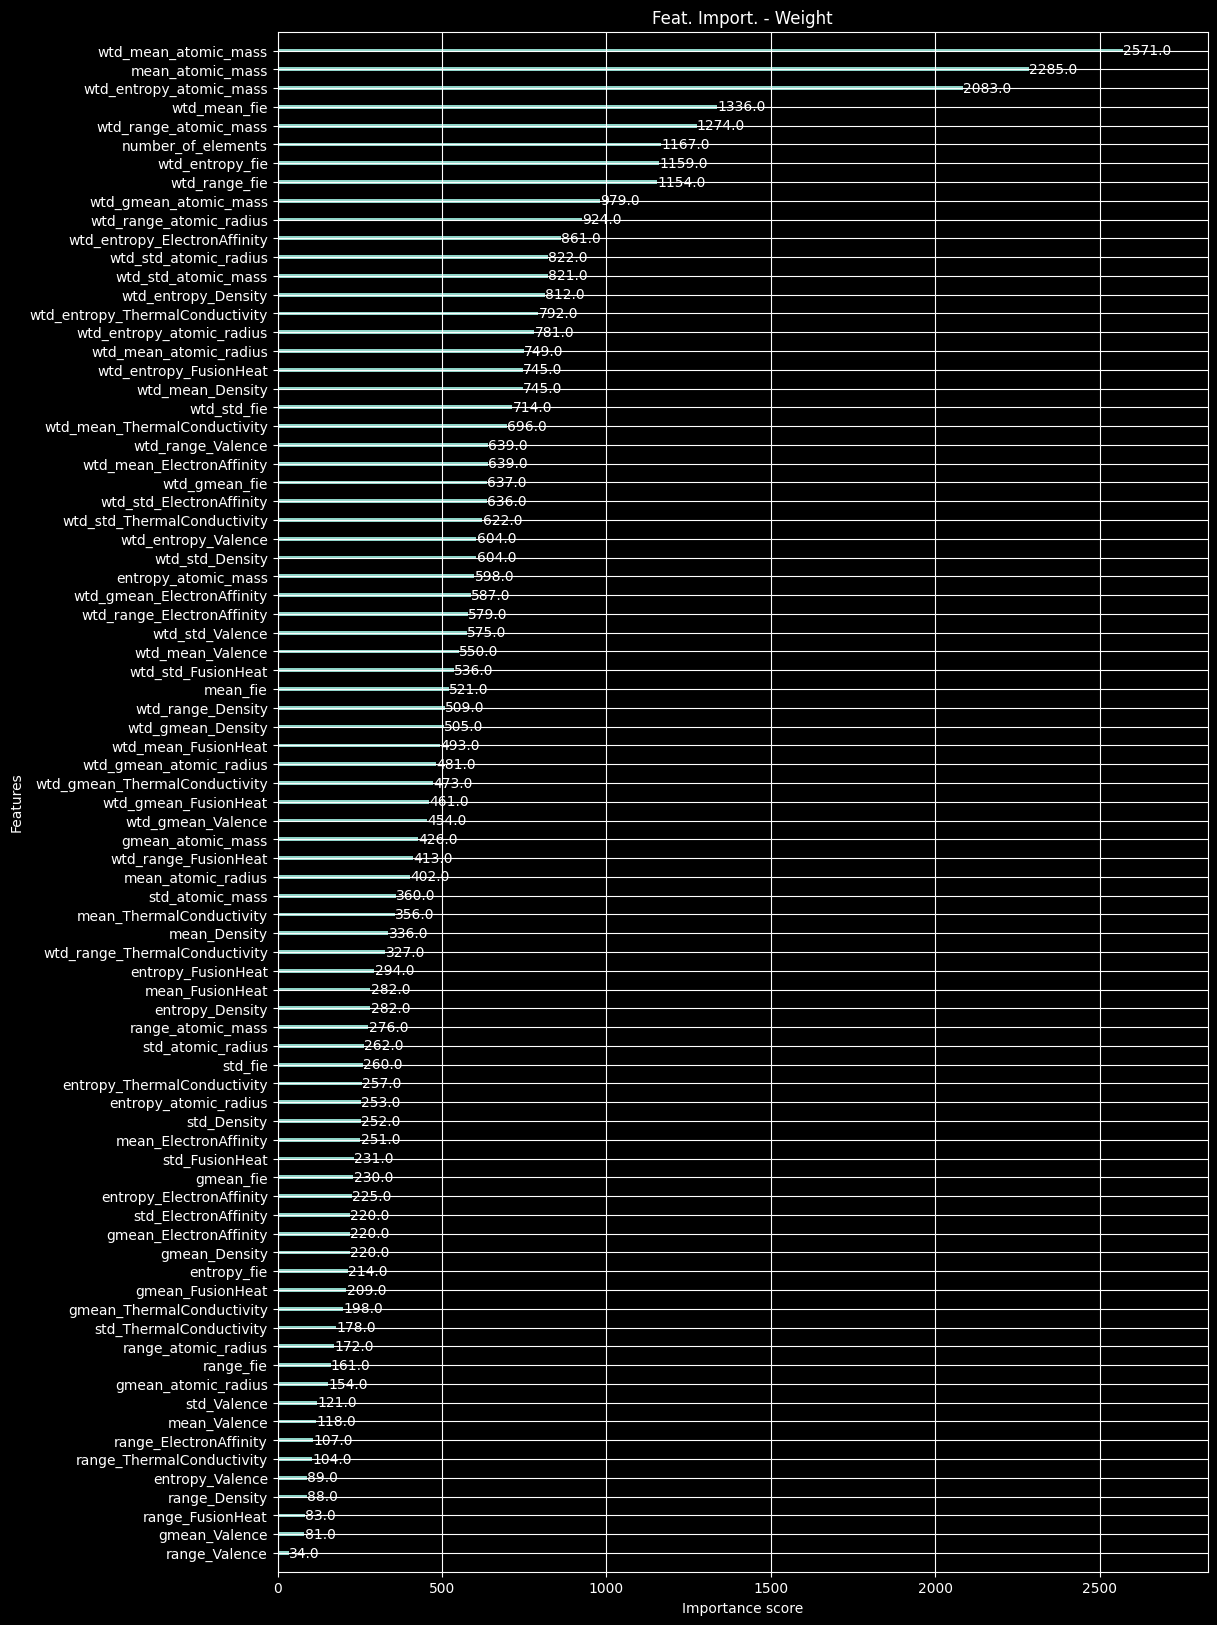

In [19]:
fig, ax = plt.subplots(figsize=(12, 20))
xgb.plot_importance(loaded_mdlv2, ax=ax, importance_type='weight', title='Feat. Import. - Weight')
plt.show()

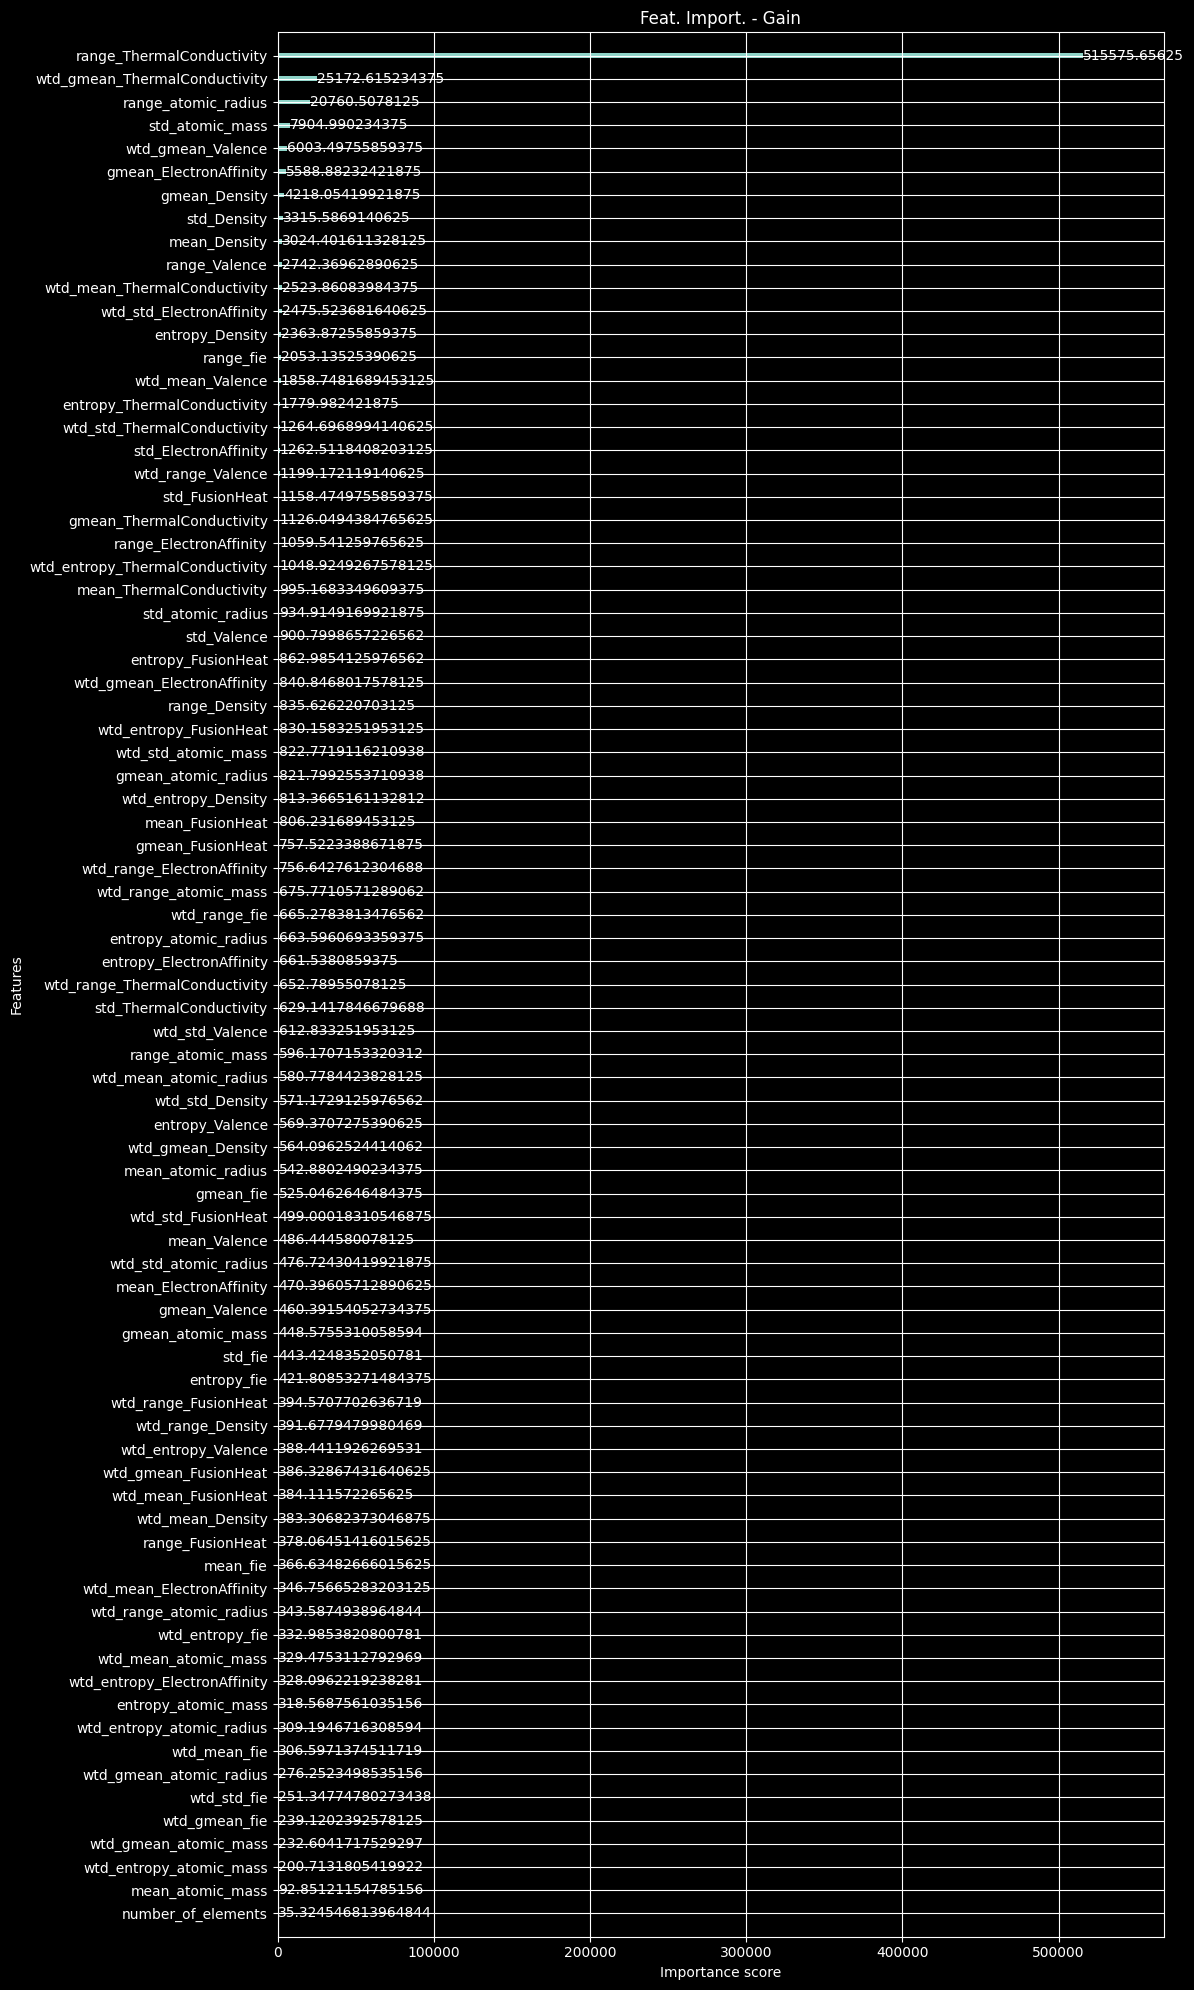

In [39]:
fig, ax = plt.subplots(figsize=(12, 20))
xgb.plot_importance(loaded_mdlv2, ax=ax, importance_type='gain', title='Feat. Import. - Gain')
# ax.set_xscale('log')
plt.tight_layout()
plt.show()

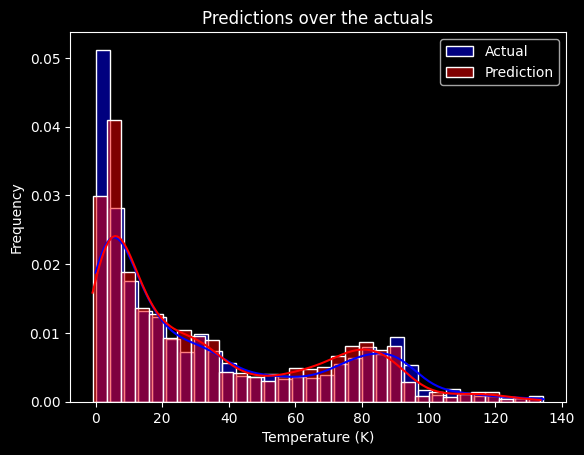

In [30]:
predv2 = loaded_mdlv2.predict(X_test)

sns.histplot(y_test, color='blue', kde=True, label='Actual', stat='density', bins=32)
sns.histplot(predv2, color='red', kde=True, label='Prediction', stat='density', bins=32)

plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Predictions over the actuals')
plt.legend()

# Show the plot
plt.show()

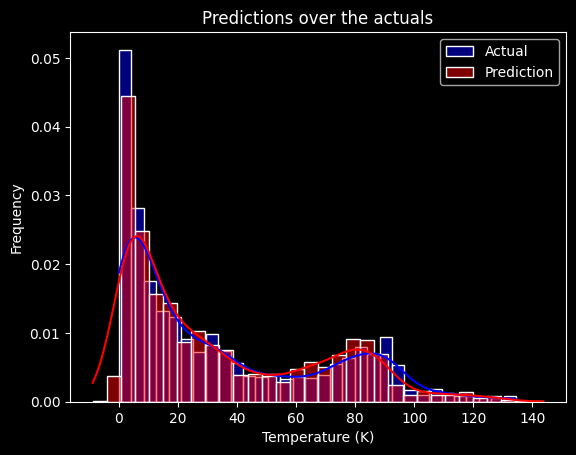

In [29]:
sns.histplot(y_test, color='blue', kde=True, label='Actual', stat='density', bins=32)
sns.histplot(pred, color='red', kde=True, label='Prediction', stat='density', bins=32)

plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Predictions over the actuals')
plt.legend()

# Show the plot
plt.show()

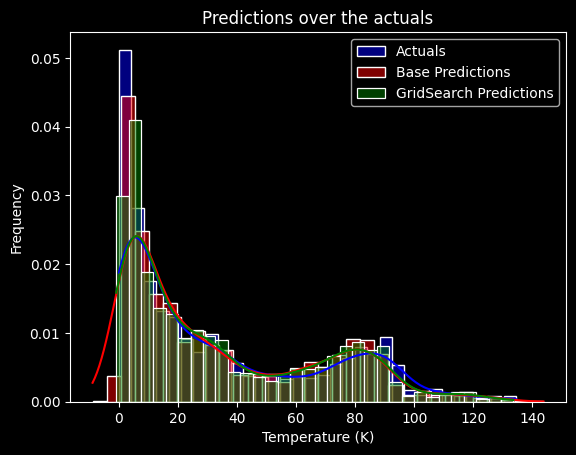

In [35]:
residuals_mdlv2 = y_test - predv2
residuals = y_test - pred

# sns.residplot(x=residuals_mdlv2, y=y_test, lowess=True, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
# plt.xlabel("Predicted")
# plt.ylabel("Residuals")
# plt.title("Residuals of mdlv2")
# plt.show()

sns.histplot(y_test, color='blue', kde=True, label='Actuals', stat='density', bins=32)
sns.histplot(pred, color='red', kde=True, label='Base Predictions', stat='density', bins=32)
sns.histplot(predv2, color='green', kde=True, label='GridSearch Predictions', stat='density', bins=32)

plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Predictions over the actuals')
plt.legend()

# Show the plot
plt.show()

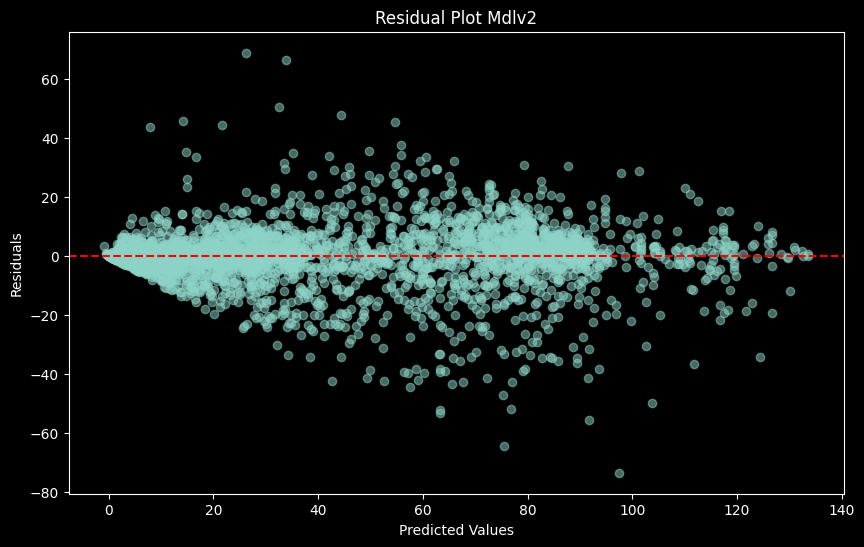

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(predv2, residuals_mdlv2, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot Mdlv2")
plt.show()

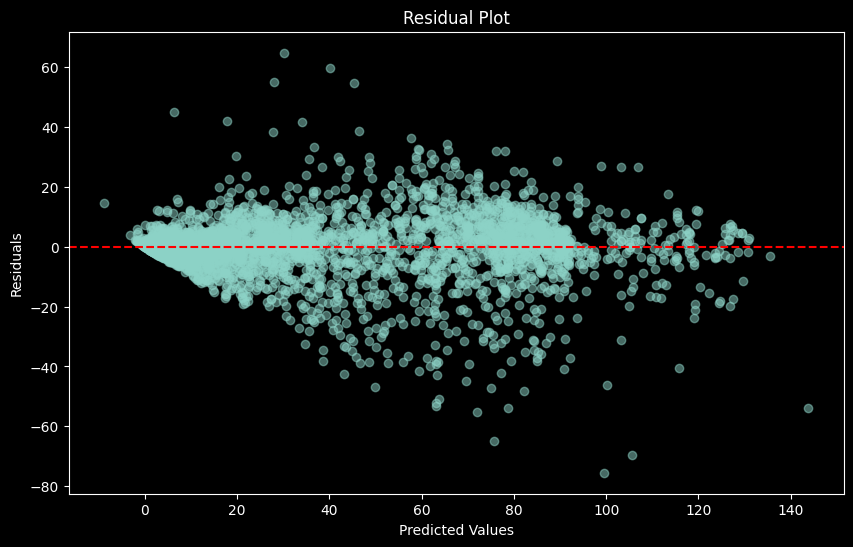

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

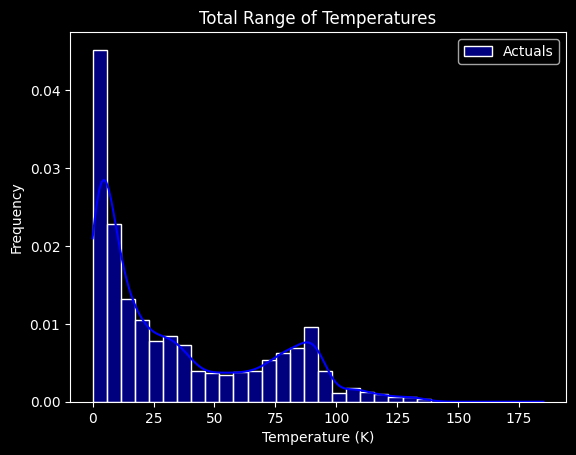

In [41]:
sns.histplot(y, color='blue', kde=True, label='Actuals', stat='density', bins=32)

plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Total Range of Temperatures')
plt.legend()

# Show the plot
plt.show()

In [46]:
print(X['range_ThermalConductivity'])

0        399.97342
1        429.97342
2        399.97342
3        399.97342
4        399.97342
           ...    
21258    134.00000
21259    399.97342
21260     17.00000
21261     17.00000
21262     78.48000
Name: range_ThermalConductivity, Length: 21263, dtype: float64


In [ ]:
# with open('thermal.txt', 'a') as f:
#     for num in X['range_ThermalConductivity']:
#         f.write(f"{num}\n")